In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [3]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/luad.TIGIT.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.TIGIT_label
0,20.896096,9.596848,2.621136,6.091040,26.987136,7222.344601,5542.944608,4488.941632,7340.434434,6629.914323,...,363.247141,404.190333,726.488530,1033.156899,546.149099,60.633336,154.321502,199.473325,91.969744,0
1,33.297296,27.611440,2.688688,16.676464,49.973760,6827.908140,5818.064608,4838.977306,6909.248278,6038.370282,...,684.119026,187.883124,441.737193,758.014409,378.138447,342.370143,628.942207,671.725133,452.277355,1
2,26.491632,9.375732,4.451024,5.667872,32.159504,7030.513740,4850.904868,3902.453701,7031.210700,6452.956778,...,695.346545,209.990838,825.215567,1240.677277,391.641612,190.890467,451.804723,510.244409,247.174210,1
3,16.196352,14.338432,5.292528,7.572624,23.768976,6421.250695,6239.398856,4833.440739,7046.967885,6479.620220,...,2280.914415,626.684330,1043.768245,1362.935754,861.248713,660.148656,840.538212,844.357253,718.836184,1
4,21.409056,7.647860,3.045184,3.017804,24.426860,7203.461019,5575.010000,2588.072893,7297.514648,6716.384490,...,260.328180,165.397297,465.228181,869.175069,252.345164,153.953542,338.395316,402.610640,184.673757,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,23.765936,57.329956,3.801792,72.332320,96.098256,6195.865412,6565.996038,5996.931267,6390.584961,5958.308663,...,2040.234736,139.569508,464.085477,686.387496,551.154643,267.525756,659.271394,828.661378,689.887650,1
316,63.962976,119.120184,26.983584,150.687472,214.650448,6459.409250,6545.221751,5078.486560,6529.722708,6316.402076,...,734.067883,295.764850,317.024359,423.207047,385.230969,207.291793,413.137374,771.809351,603.590634,0
317,1.333536,3.458368,1.725584,110.496016,111.829552,2268.824304,3221.368807,5159.867289,5058.554594,1519.343410,...,14784.696625,374.193123,671.414956,1084.030034,1075.565428,179.222758,511.512945,430.232706,427.239483,0
318,35.620352,35.469832,25.362688,23.217568,58.837920,5833.738689,6248.578618,5167.807759,5772.045809,5422.754758,...,773.905672,280.541866,288.160372,496.132928,365.614556,54.238655,206.739068,371.572079,179.459097,1


In [4]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,-0.749013,-1.072117,-0.589537,-1.067952,-1.068277,0.921865,-0.857187,-1.293219,1.049011,1.068841,...,-0.681360,-0.601701,0.980096,2.119064,1.680447,0.680333,-0.585046,-1.056026,-1.195126,-1.132746
1,-0.490401,-0.765295,-0.586671,-0.857406,-0.794244,0.473502,-0.539116,-0.921893,0.415443,0.440480,...,-0.339643,-0.331624,-0.066438,0.631990,0.668060,-0.041889,1.436321,0.331994,-0.360313,-0.158599
2,-0.632325,-1.075883,-0.511900,-1.076368,-1.006615,0.703807,-1.657266,-1.915380,0.594650,0.880870,...,-0.054912,-0.322174,0.040523,2.634652,2.444019,0.016157,0.349505,-0.186041,-0.645767,-0.713127
3,-0.847021,-0.991359,-0.476197,-1.038483,-1.106643,0.011247,-0.052004,-0.927766,0.617803,0.909193,...,1.593067,1.012394,2.056563,3.776013,2.893869,2.034842,3.716276,0.950803,-0.055146,0.562083
4,-0.738316,-1.105312,-0.571546,-1.129079,-1.098800,0.900400,-0.820115,-3.309708,0.985947,1.160693,...,-0.842152,-0.688328,-0.175229,0.754669,1.077076,-0.582633,0.084495,-0.517705,-0.836035,-0.882106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,-0.689166,-0.259133,-0.539445,0.249599,-0.244373,-0.244952,0.325581,0.306494,-0.346662,0.355436,...,0.556377,0.809815,-0.300188,0.748701,0.404509,0.701850,0.899338,0.420691,-0.082892,0.483816
316,0.149096,0.793271,0.444091,1.808097,1.168941,0.054623,0.301563,-0.667815,-0.142218,0.735816,...,-0.661752,-0.289582,0.455514,-0.019305,-0.563863,-0.011401,0.467179,-0.299124,-0.183391,0.250499
317,-1.156967,-1.176667,-0.627533,1.008682,-0.056833,-4.708888,-3.541201,-0.581485,-2.303897,-4.359800,...,9.549882,11.536795,0.834964,1.831450,1.867635,2.956119,0.265793,-0.011426,-0.787206,-0.226293
318,-0.441956,-0.631452,0.375321,-0.727302,-0.688570,-0.656588,-0.041391,-0.573061,-1.255520,-0.213450,...,-0.155966,-0.256051,0.381862,-0.170043,-0.295532,-0.095725,-0.630926,-0.902732,-0.890902,-0.896205


In [5]:
y = df.iloc[:,607]
print(np.sum(y))

161


In [6]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/LUAD.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 20


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,1
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,1
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,20
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,1
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,1


## Define Nested CV Parameters

In [7]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

106 106
107 107
107 107
0.5
0.5046728971962616
0.5046728971962616


### Outer Loop 1

In [23]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(213, 607) (213,)
(107, 607) (107,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.698227169655741, 0.7013605442176871, 0.7026798598227171, 0.7052978767264481, 0.7053184910327767, 0.7105751391465678, 0.7115027829313544, 0.7178519892805608, 0.7204700061842919, 0.7177489177489178, 0.7212945784374355, 0.7374561945990518, 0.7111935683364254, 0.7368789940218512, 0.7354978354978355, 0.729148629148629, 0.7498453927025356, 0.7323232323232324, 0.7351886209029066, 0.7264893836322408, 0.7202432488146775, 0.699134199134199, 0.7280766852195424, 0.7183261183261183, 0.7241393527107812, 0.7064935064935065, 0.6432488146773861, 0.5151515151515151, 0.5, 0.5]


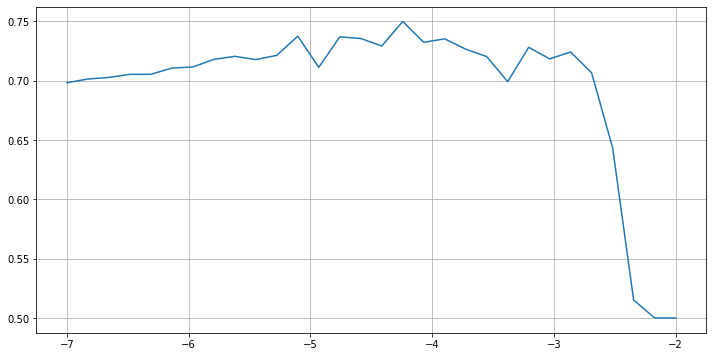

0.014387733001540358 -4.241379310344827


In [11]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

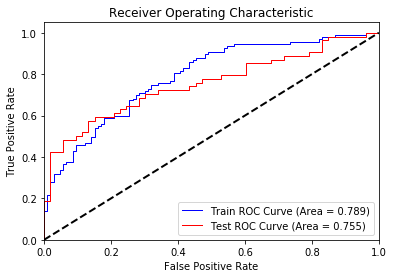

In [25]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

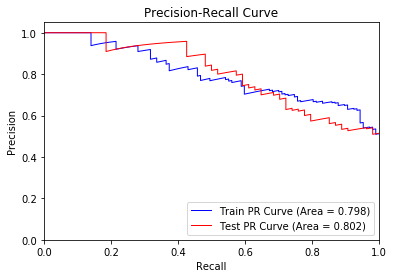

In [26]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [27]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 71


,HIF,Beta,Cluster
114,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.203547,13
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.199684,13
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.198275,1
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.160061,13
517,REGION PROPERTIES: PERIMETER^2 / AREA OF SIGNIFICANT REGIONS OF STROMA_HE,0.138703,1
...,...,...,...
41,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF MACROPHAGE IN ESI_0080_HE,-0.079435,1
554,REGION PROPERTIES: TOTAL FILLED AREA (MM2) OF STROMA_HE,-0.093297,1
464,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF ESI_0080_HE,-0.100072,1
453,REGION PROPERTIES: EXTENT OF LARGEST REGION OF NECROSIS_HE,-0.257106,2


### Outer Loop 2

In [28]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(213, 607) (213,)
(107, 607) (107,)


In [27]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7035456606885179, 0.7092764378478664, 0.7127396413110699, 0.7123273551844981, 0.7089672232529376, 0.694186765615337, 0.7100185528756958, 0.6870748299319727, 0.7056895485466914, 0.7096474953617811, 0.6973613687899402, 0.707833436404865, 0.726427540713255, 0.7188414759843331, 0.7115027829313544, 0.7103689960832819, 0.7204493918779634, 0.7070913213770357, 0.7050711193568336, 0.7242218099360956, 0.7146980004122861, 0.702473716759431, 0.693382807668522, 0.6898989898989899, 0.6904143475572048, 0.6890538033395177, 0.6805607091321377, 0.6725211296639868, 0.7280972995258709, 0.7090909090909091]


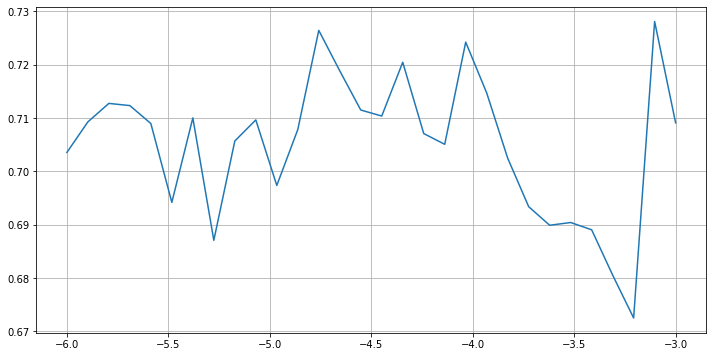

0.044894127839919556 -3.103448275862069


In [29]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

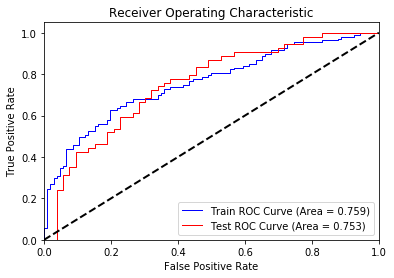

In [30]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

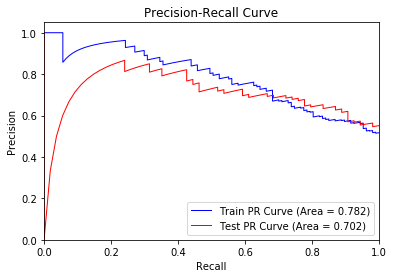

In [31]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 284


,HIF,Beta,Cluster
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.454477,13
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.421466,13
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.198110,13
498,REGION PROPERTIES: NUMBER OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.151554,16
268,COUNT PROP [[[CANCER CELLS] SELECTED BY [FIBROBLAST_RADIUS_80]] OVER [CANCER CELLS]] IN [EPITHEL...,0.134963,13
...,...,...,...
533,REGION PROPERTIES: STANDARD DEVIATION OF EXTENTS OF SIGNIFICANT REGIONS OF NECROSIS_HE,-0.051689,16
465,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF NECROSIS_HE,-0.055384,16
469,REGION PROPERTIES: FRACTAL DIMENSION OF STROMA_HE,-0.061558,1
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,-0.185901,2


### Outer Loop 3

In [33]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(214, 607) (214,)
(106, 607) (106,)


In [50]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.7473922902494332, 0.7499896928468358, 0.7547515976087406, 0.7569779426922284, 0.7582354153782725, 0.7591424448567305, 0.7621933621933621, 0.7678210678210678, 0.7618016903731188, 0.7588126159554731, 0.7570603999175428, 0.7482993197278912, 0.7440321583178727, 0.7363430220573077, 0.7401154401154401, 0.7518655947227376, 0.7401154401154402, 0.7522366522366523, 0.7400123685837972, 0.7376829519686663, 0.7392908678622965, 0.7341166769738198, 0.735827664399093, 0.7344877344877345, 0.7315192743764172, 0.7276231704803134, 0.7228200371057514, 0.7074417645846218, 0.7118738404452691, 0.6967223252937538]


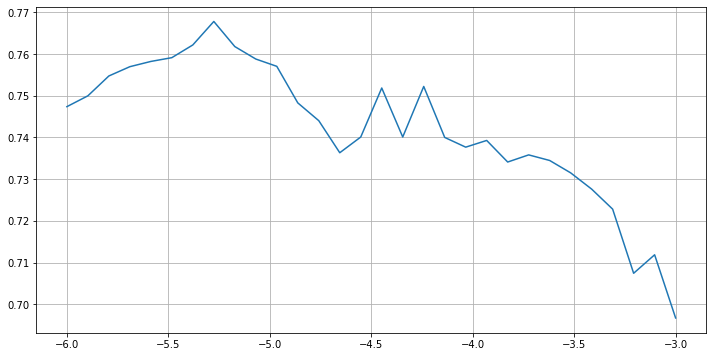

0.005113546577819013 -5.275862068965517


In [52]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.7
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

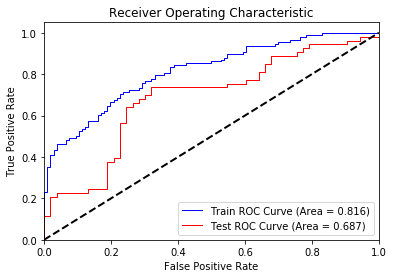

In [35]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

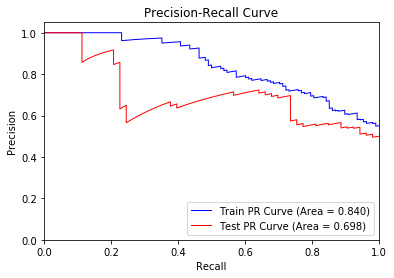

In [36]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [37]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 102


,HIF,Beta,Cluster
265,COUNT PROP [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [ESI_0080]_HE,0.437512,8
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.299422,13
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.292964,11
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.214381,13
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.187903,1
...,...,...,...
573,TOTAL [CANCER CELLS] IN [EPITHELIAL] SELECTED BY [MACROPHAGE_RADIUS_80]_HE,-0.124326,1
168,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF CANCER IN EPITHELIAL_HE,-0.141983,14
108,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF CANCER IN EPITHELIAL_HE,-0.142520,14
443,REGION PROPERTIES: ECCENTRICITY OF LARGEST REGION OF NECROSIS_HE,-0.146560,19


## Compute Ensemble Model

In [38]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.199684,0.454477,0.299422,13,0.317861
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.137743,0.421466,0.214381,13,0.257863
174,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.160061,0.198110,0.103624,13,0.153932
265,COUNT PROP [[LYMPHOCYTE CELLS] OVER [CANCER CELLS]] IN [ESI_0080]_HE,0.000000,0.000000,0.437512,8,0.145837
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.198275,0.000000,0.187903,1,0.128726
...,...,...,...,...,...,...
573,TOTAL [CANCER CELLS] IN [EPITHELIAL] SELECTED BY [MACROPHAGE_RADIUS_80]_HE,-0.014022,-0.027066,-0.124326,1,-0.055138
468,REGION PROPERTIES: FRACTAL DIMENSION OF NECROSIS_HE,-0.010795,-0.185901,0.000000,2,-0.065565
425,REGION PROPERTIES: AVERAGE ECCENTRICITY OF SIGNIFICANT REGIONS OF TUMOR_HE,0.000000,0.000000,-0.313004,17,-0.104335
443,REGION PROPERTIES: ECCENTRICITY OF LARGEST REGION OF NECROSIS_HE,-0.482589,-0.004291,-0.146560,19,-0.211146


## Compute Final Train / Test Metrics

In [39]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.788926115323576, 0.759037206841827, 0.8156009783368274]
0.7878547668340768 0.023104485886570762


In [40]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.7547169811320755, 0.7533193570929421, 0.6870772516909933]
0.7317045299720036 0.031561409065679585


In [41]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.7984309105284186, 0.7815131781977204, 0.8396563559925037]
0.806533481572881 0.02441851789341938


In [42]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.8022051652492113, 0.701615530524863, 0.6982137916555242]
0.7340114958098661 0.0482402001829442


## Evaluate Hold-Out Set

In [43]:
holdout_df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/luad.tigit.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE,joined.TIGIT_label
0,136.661136,159.244844,13.627104,124.760496,261.421632,6569.555773,6196.871210,5883.111381,6845.927703,6511.041537,...,324.892777,267.874255,300.876303,400.311009,331.078187,183.841586,300.662796,435.233922,303.815715,0
1,39.920912,69.314676,5.315152,64.545840,104.466752,6519.085240,6684.527789,6467.939404,6743.460348,5011.467504,...,617.804218,121.064368,412.986133,855.887847,575.082491,65.679862,750.461562,1296.954227,826.435190,1
2,62.302536,129.819836,5.933816,178.632208,240.934744,6336.653660,6287.289649,6727.715056,6762.129199,5006.195021,...,2372.671498,189.446542,488.607920,856.816370,684.243365,193.988893,762.133146,877.585301,700.816317,1
3,74.309088,125.439476,12.137280,166.299872,240.608960,5699.687863,6511.093987,5531.920743,6012.873158,5063.523013,...,1480.244127,152.282854,428.031125,747.120238,563.412102,139.242726,794.143942,828.449225,615.596360,1
4,67.641900,95.316000,31.037048,54.533612,122.175512,6456.923068,6873.572132,6193.082487,6650.332045,6189.983149,...,288.895863,22.826089,167.254186,433.604141,206.178796,65.211060,129.254270,236.276299,141.566831,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16.295424,22.866624,3.175088,12.735248,29.030672,7410.985019,7204.818710,6976.726907,7460.400035,6296.664491,...,1199.455528,171.459178,442.347764,909.601446,495.269279,155.994714,654.316090,1670.481800,820.373707,1
96,96.848160,54.131324,13.223424,21.179504,118.027664,7320.798988,6005.536544,5830.458945,7213.837199,5145.353655,...,80.260845,8.311980,69.811705,433.060189,84.531030,3.851390,37.187341,143.251702,28.866114,0
97,8.241392,11.694380,6.631776,10.866672,19.108064,5981.225129,6573.416890,5682.214054,6185.403365,5174.081836,...,706.350994,295.702474,491.518148,810.551749,588.494994,248.259032,1005.183687,1339.048423,868.586163,1
98,3.746672,8.019604,2.764032,10.716912,14.463584,6380.083503,6371.211659,6912.881810,6738.488914,6184.440881,...,355.928378,111.031870,167.963406,228.610630,198.152823,185.231053,463.863303,493.705650,413.797853,1


In [44]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._HE,AREA..MM2..OF..ESI_0080..IN..TISSUE._HE,AREA..MM2..OF..NECROSIS..IN..TISSUE._HE,AREA..MM2..OF..STROMA..IN..TISSUE._HE,AREA..MM2..OF..TUMOR..IN..TISSUE._HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_HE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_HE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._HE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._HE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._HE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._HE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._HE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._HE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._HE,DENSITY..PLASMA.CELLS..IN..ESI_0080._HE,DENSITY..PLASMA.CELLS..IN..STROMA._HE,DENSITY..PLASMA.CELLS..IN..TUMOR._HE
0,3.169423,3.204888,0.435793,2.820524,3.409676,0.296934,-0.204136,-0.175731,0.478625,1.296420,...,-1.120327,-0.897969,-0.073899,-0.345946,-0.707181,-0.419859,0.005902,-0.646666,-0.767241,-0.642378
1,0.290168,0.835841,-0.230265,1.018467,0.743657,0.221812,0.529739,0.607422,0.298387,-0.554117,...,-0.460911,-0.298768,-0.567230,-0.022460,0.299485,0.168460,-0.493378,0.254693,0.329245,0.463036
2,0.956306,2.429740,-0.180689,4.432754,3.061688,-0.049726,-0.068065,0.955292,0.331225,-0.560623,...,2.291511,3.291117,-0.337443,0.195742,0.301537,0.431657,0.048778,0.278082,-0.204376,0.197334
3,1.313654,2.314347,0.316410,4.063681,3.056154,-0.997811,0.268738,-0.646017,-0.986701,-0.489878,...,0.934645,1.465502,-0.462326,0.020952,0.059146,0.140321,-0.182546,0.342229,-0.266899,0.017082
4,1.115221,1.520799,1.830896,0.718829,1.044456,0.129287,0.814232,0.239356,0.134576,0.900221,...,-0.987713,-0.971607,-0.897345,-0.731504,-0.633614,-0.721004,-0.495359,-0.990154,-1.020403,-0.985557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.412992,-0.387748,-0.401753,-0.532079,-0.537692,1.549350,1.312726,1.288748,1.559469,1.031870,...,1.207401,0.891101,-0.397887,0.062261,0.418173,-0.023978,-0.111762,0.062025,0.804536,0.450215
96,1.984479,0.435863,0.403445,-0.279366,0.974001,1.415114,-0.492076,-0.246239,1.125770,-0.388896,...,-1.206915,-1.398406,-0.946117,-1.012668,-0.634816,-1.014309,-0.754628,-1.174648,-1.138771,-1.223935
97,-0.652702,-0.682061,-0.124760,-0.588000,-0.706237,-0.578760,0.362528,-0.444756,-0.683224,-0.353444,...,-0.329965,-0.117630,0.019613,0.204140,0.199308,0.200799,0.278091,0.765134,0.382808,0.552191
98,-0.786477,-0.778866,-0.434692,-0.592482,-0.785127,0.014916,0.058229,1.203252,0.289642,0.893381,...,-1.136624,-0.834480,-0.600943,-0.729458,-1.086578,-0.740355,0.011773,-0.319626,-0.692840,-0.409750


In [45]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

60


In [46]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [47]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

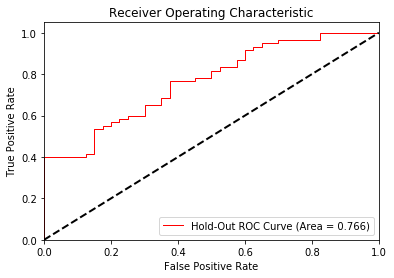

In [48]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.766


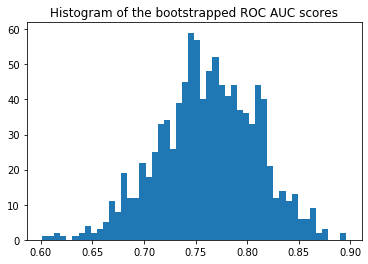

Confidence interval for the score: [0.670 - 0.852]


In [49]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

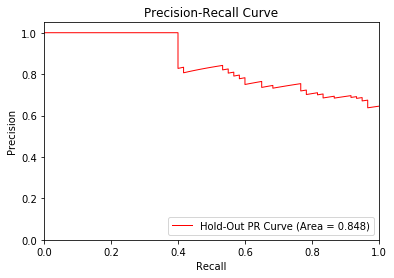

In [50]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.848


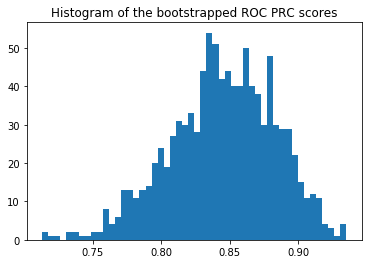

Confidence interval for the score: [0.766 - 0.911]


In [51]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))